# Things I have done to the train set 

1. Dropped column `c10` as it is just a copy of the target. 

# PhData Take Home
### November 2024
### Michael Rowlands



# Problem Statement, Framing, and Assumptions




## Questions to Ask the Client Before Proceeding if This Were Real

### **1. Business Context**
1. **Definition of `successful_sell`:**
   - What constitutes a successful sale in your terms? Does it include partial sales or upsells, or is it strictly binary (sale vs. no sale)?
2. **Sales process details:**
   - How is customer data collected, and does it reflect the most current or relevant customer interactions?
   - Are there any key factors you already know affect sales success (e.g., time of year, customer demographics)?
3. **Use of predictions:**
   - What do you plan to do with the predictions? For example:
     - Prioritize leads most likely to result in a sale.
     - Design targeted marketing strategies.
     - Improve sales team allocation.
   
4. **Costs and risks:**
   - How will prediction errors (false positives or false negatives) affect the business?
      - What is the cost of attempting a sale and failing (false positive)?
      - What is the opportunity cost of missing a likely sale (false negative)?
      - How sensitive is the business to errors in predictions?

---

### **2. Dataset and Features**
5. **Feature definitions:**
   - What do the cryptic column names (e.g., `b1`, `c10`) represent? Can you provide documentation or context for these features?
   - Are there features that are proxies for the sales process (e.g., length of customer interaction)?
6. **Data quality:**
   - Are there known issues in the dataset (e.g., outdated values, manual errors)?
   - Are missing or "unknown" values in columns like `c8` meaningful (e.g., absence of data indicating no interaction)?
7. **External data:**
   - Are there other datasets or contextual factors (e.g., customer income, regional economic trends) that could enhance prediction accuracy?

---

### **3. Model Deployment and Metrics**
8. **Time constraints:**
   - How frequently will the model need to generate predictions? (e.g., real-time, daily, or batch processing)
9. **Preferred evaluation metric:**
   - Would you prioritize reducing false negatives or false positives?
10. **Thresholding:**
    - Do you prefer probabilistic outputs (e.g., likelihood of success) or strict binary predictions?

---


# Data Exploration

In [1]:
import polars as pl
import pandas as pd
import pyarrow as pa
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [123]:
df = pl.read_csv("phdata-ds-project-challenge/project_data.csv")

df.shape

(41188, 23)

We see that the data has 41,188 rows and 23 columns. 

We will create a training set of 20% and put it aside for now to avoid data leakage.

In [65]:
# Create a test set with 20% of the data and put it away for later  
df_train, df_test = train_test_split(df,test_size=0.2, random_state=42, stratify=df['successful_sell'])

In [122]:
df_train.describe()

statistic,age,b1,b2,c10,c3,c4,c8,dow,employment,i1,i2,i3,i4,i5,marriage-status,month,n2,n3,n4,n5,n6,school,successful_sell
str,f64,str,str,str,str,str,str,str,str,f64,f64,f64,f64,f64,str,str,f64,f64,f64,f64,f64,str,str
"""count""",32950.0,"""32950""","""32158""","""32950""","""32950""","""32950""","""4474""","""32950""","""32950""",32950.0,32950.0,32950.0,32950.0,32950.0,"""32885""","""32950""",32950.0,32950.0,1209.0,32950.0,32950.0,"""31594""","""32950"""
"""null_count""",0.0,"""0""","""792""","""0""","""0""","""0""","""28476""","""0""","""0""",0.0,0.0,0.0,0.0,0.0,"""65""","""0""",0.0,0.0,31741.0,0.0,0.0,"""1356""","""0"""
"""mean""",39.979545,null,null,null,null,null,null,null,null,0.084886,93.576477,-40.503256,3.623675,5167.108267,null,null,2.561184,745.203945,6.071133,-0.00503,0.171624,null,null
"""std""",10.38556,null,null,null,null,null,null,null,null,1.568264,0.577874,4.621316,1.733466,72.284747,null,null,2.748329,144.361902,3.944344,0.997157,0.490786,null,null
"""min""",17.0,"""-1""","""no""","""no""","""False""","""new""","""no""","""fri""","""assistant""",-3.4,92.201,-50.8,0.634,4963.6,"""divorced""","""apr""",1.0,500.0,0.0,-4.354231,0.0,"""0 - none""","""no"""
"""25%""",32.0,null,null,null,null,null,null,null,null,-1.8,93.075,-42.7,1.344,5099.1,null,null,1.0,620.0,3.0,-0.686762,0.0,null,null
"""50%""",38.0,null,null,null,null,null,null,null,null,1.1,93.749,-41.8,4.857,5191.0,null,null,2.0,750.0,6.0,0.000114,0.0,null,null
"""75%""",47.0,null,null,null,null,null,null,null,null,1.4,93.994,-36.4,4.961,5228.1,null,null,3.0,870.0,7.0,0.671833,0.0,null,null
"""max""",98.0,"""yes""","""yes""","""yes""","""unknown""","""old""","""yes""","""wed""","""unknown""",1.4,94.767,-26.9,5.045,5228.1,"""single""","""sep""",43.0,990.0,27.0,4.547729,7.0,"""5 - a lot""","""yes"""


# Initial Dataset Overview and Observations

## **Potential Data Quality Concerns**
1. **High `null_count` in some columns:**
   - `c8`: 28,476 out of 32,950 records are missing (86% missing).
   - `b2`: 792 missing values (2% missing).
   - `school`: 1,356 missing values (4% missing).

2. **Odd values in categorical columns:**
   - `b1` includes values like `"-1"` and `"yes"`, which seem inconsistent.
   - `c3` and `c4` contain categories such as `"False"`, `"new"`, `"old"`, and `"unknown"`, which might need clarification or standardization.


---

## **Statistical Patterns**
1. **Wide range of `age`:**
   - The minimum is 17, and the maximum is 98. Values near the extremes should be checked for validity or outliers.

2. **Odd statistics in numeric columns:**
   - **`i2`**: Mean (93.57) and standard deviation (0.577874) suggest an extremely narrow range. This column might have limited variance or near-constant values.
   - **`n4`**: 25th Percentile - Max are all 999 possibly indicating some sort of missing encoding. 
   - **`n5`**: The mean (-0.00503) is close to zero, and the range spans negative and positive values, suggesting possible normalization or standardization.
   - **`n6`**: Most values are 0, but a max of 7. All integer values. Looks like it could be generated from a poisson (zero-inflated poisson), but could possibly be a categorical column as well (not likely after viewing histogram below)

3. **Non-intuitive statistics in `i5`:**
   - While `i5` has a narrow range (min: 4963.6, max: 5228.1), the percentiles (25%, 50%, 75%) indicate potential skewness.

4. **Potential categorical misalignment:**
   - Categorical columns like `marriage-status` and `month` appear consistent (e.g., `"divorced"`, `"apr"`), but `"unknown"` values in other columns might require preprocessing.

---

## **Questions for Clarification**

1. **Definitions of numeric columns:**
   - Columns like `i1`, `i3`, and `i5` need clarification. Are these normalized, scaled metrics, or raw values?

2. **Handling of unknowns:**
   - `"unknown"` appears in multiple columns (`c10`, `dow`, `employment`). Decide whether these are valid data points or placeholders needing imputation or exclusion.

3. **Consistency in categories:**
   - Columns like `b1` (`"-1"` and `"yes"`) and others with mixed categories should be reviewed for mutual exclusivity and validity.

---

## **Next Steps**
- **Imputation or exclusion for missing data:** 
  - Highly sparse columns like `c8` may be uninformative and should be excluded unless imputation is feasible.
- **Data type conversions:**
  - Convert numeric-like strings to appropriate types (e.g., `b1` to categorical/binary).
- **Standardize categories:**
  - Review columns like `b2`, `c3`, and `c4` for consistency in categories.
- **Outlier checks:**
  - Investigate extreme values in columns like `age`, `n4`, and others for potential data errors.
- **Clarify column meanings:**
  - Properly define numeric columns (`i1`–`i5`, `n2`–`n6`) to interpret their statistics meaningfully.

---

## **Questions I would ask the client about this data**
1. 

In [67]:
df_train['successful_sell'].value_counts(normalize=True)


successful_sell,proportion
str,f64
"""yes""",0.112656
"""no""",0.887344


We see that we have a split of around 89% no sales to 11% sales. A naive model would have around an 89% accuracy predicting the majority class for all observations.

/var/folders/qg/45gghp392ss6b8g9j5l7td380000gn/T/ipykernel_92297/1864589202.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
/var/folders/qg/45gghp392ss6b8g9j5l7td380000gn/T/ipykernel_92297/1864589202.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
/var/folders/qg/45gghp392ss6b8g9j5l7td380000gn/T/ipykernel_92297/1864589202.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
/var/folders/qg/45gghp392ss6b8g9j5l7td380000gn/T/ipykernel_92297/1864589202.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a Fi

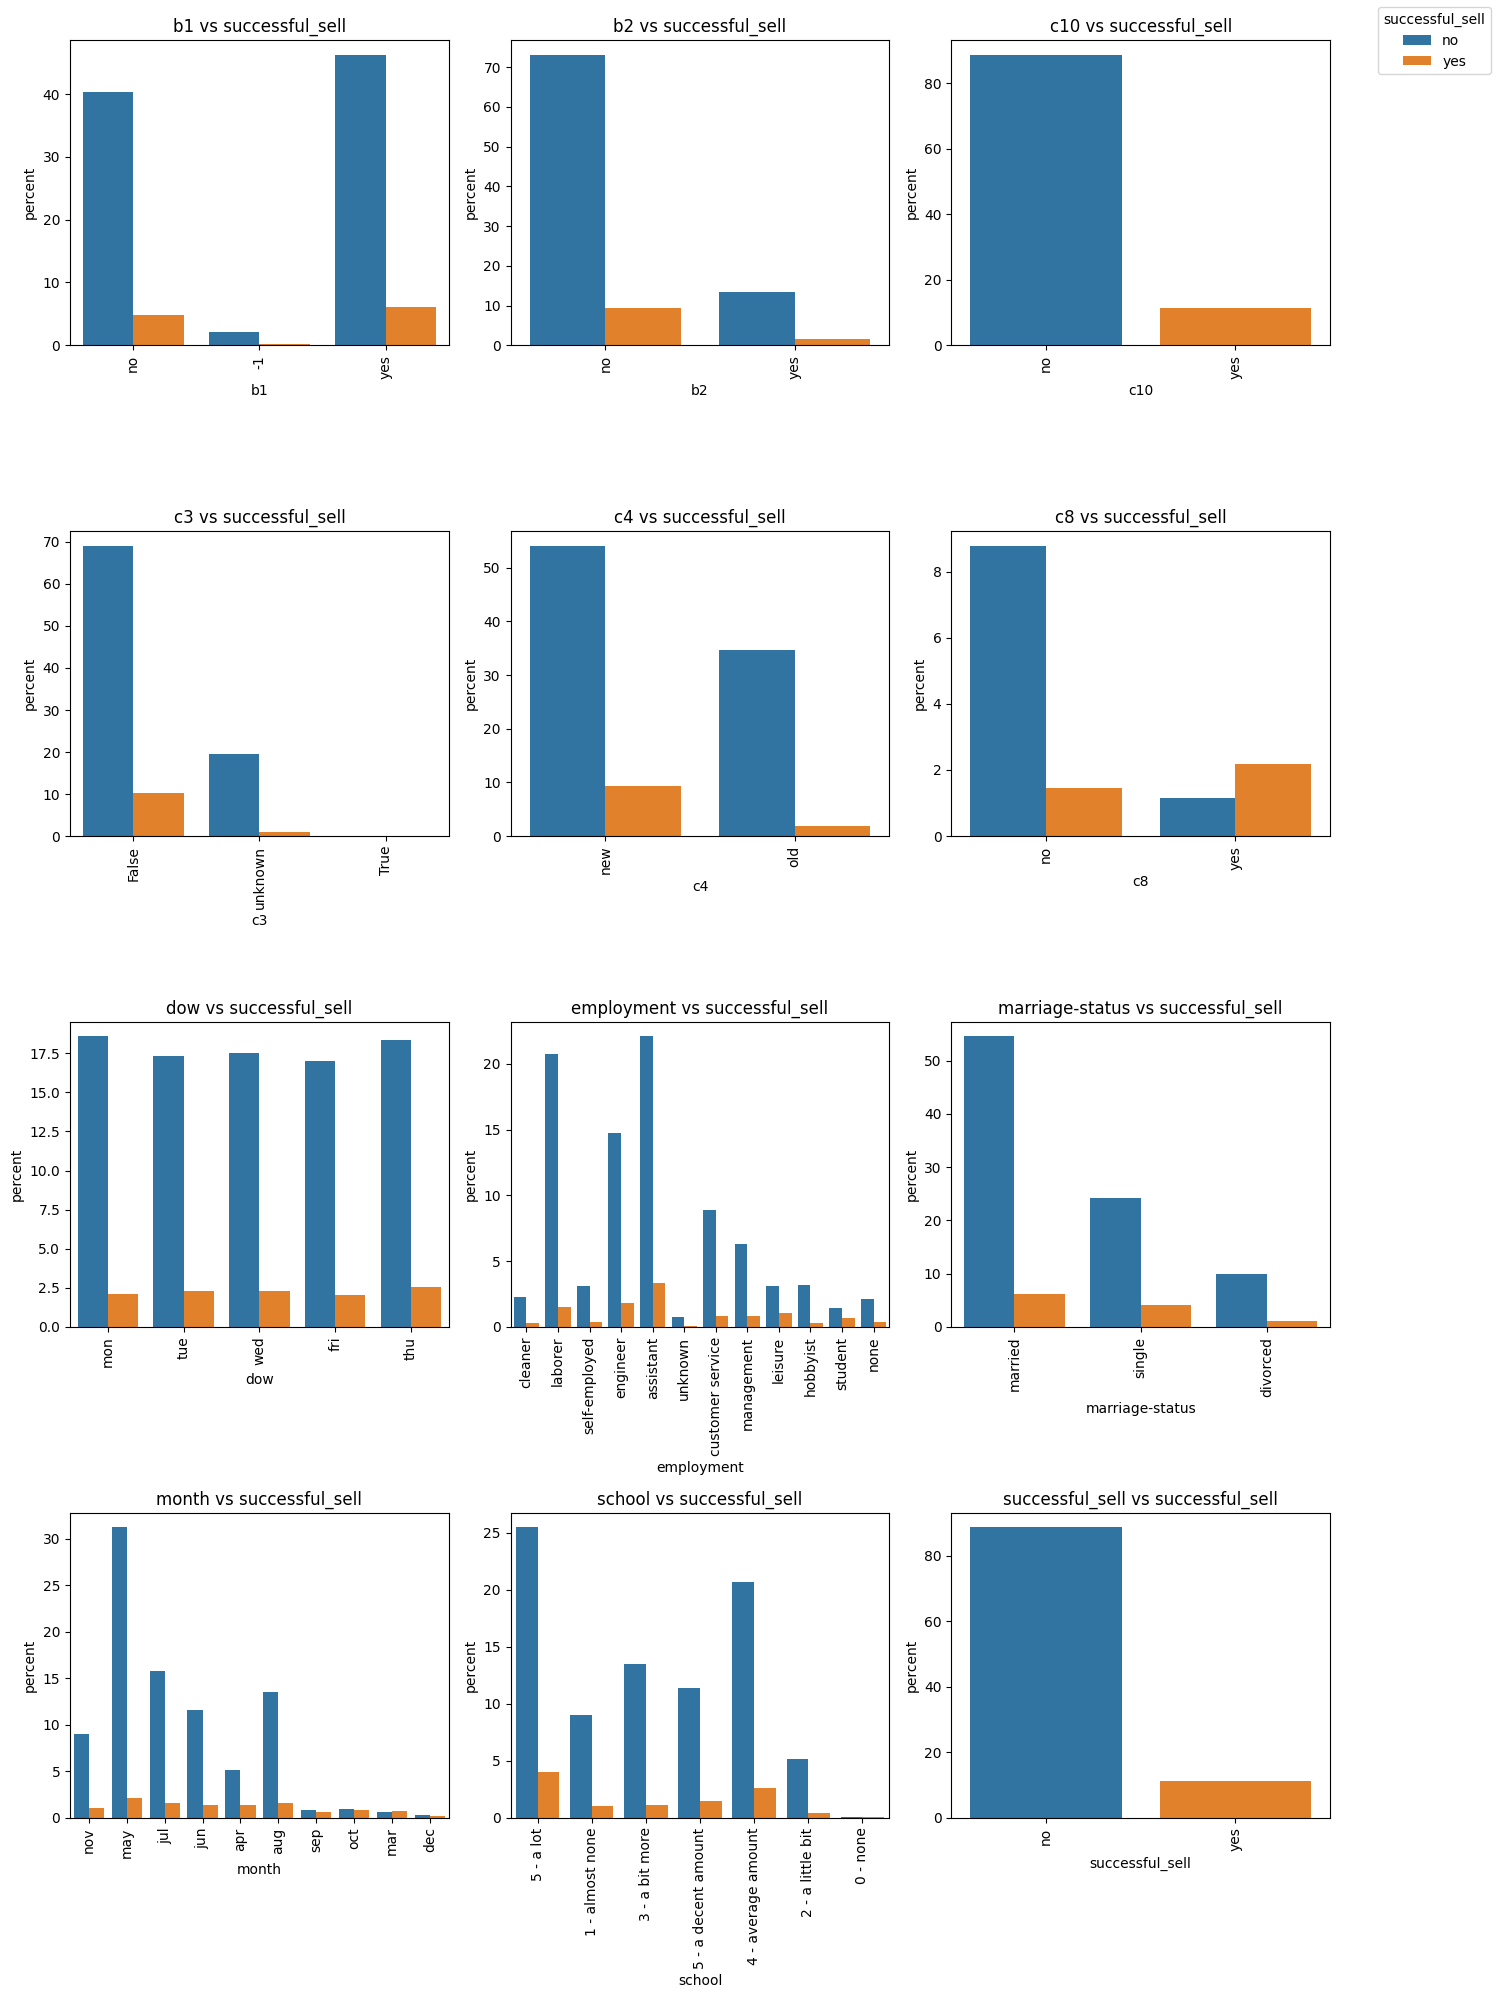

In [69]:
# Subset to categorical cols
cat_cols = [col for col in df_train.columns if df_train[col].dtype == pl.String]

fig, axes = plt.subplots(4, 3, figsize=(15, 20))

axes = axes.flatten()

# Store handles and labels for the legend
handles, labels = None, None

# Iterate over the categorical columns and plot each one
for i, col in enumerate(cat_cols):
    ax = axes[i]
    
    # Create count plot
    plot = sns.countplot(x=col, hue='successful_sell', data=df_train, ax=ax, stat='percent')
    
    # Capture handles and labels from the first plot
    if i == 0:
        handles, labels = ax.get_legend_handles_labels()
    
    # Remove individual legends if they exist
    if ax.get_legend() is not None:
        ax.get_legend().remove()
    
    # Set the title of the subplot
    ax.set_title(f'{col} vs successful_sell')
    
    # Set the labels for x and y axes
    ax.set_xlabel(col)
    ax.set_ylabel('percent')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

# Create one legend for the entire plot
fig.legend(handles, labels, title='successful_sell', loc='upper right')

# Adjust the layout and display the plot
plt.tight_layout(rect=[0, 0, 0.9, 1])  # Leave space for the legend
plt.show()


First thing to notice here is that c10 is probably just another labeling of successful_sell so let's check that and remove it if it is the case. 

In [70]:
# Print count of rows where successful_sell and c10 are not equal
df_train.filter(pl.col("successful_sell") != pl.col('c10')).shape[0]

0

So c10 is undoubtably just a recoding of successful_sell, so we will remove it from our training data (and later from our test data along with the rest of the preprocessing we will do).

In [55]:
df_train = df_train.drop('c10')

In [79]:
len(num_cols)

11

Other things of note are DOW seems like it doesn't vary much so it might not be super predictive

Month seems to have some decent variation. Months with smaller counts seem to have higher sales conversions. Might be due to something like those who are reaching out 

/var/folders/qg/45gghp392ss6b8g9j5l7td380000gn/T/ipykernel_92297/1665023665.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
/var/folders/qg/45gghp392ss6b8g9j5l7td380000gn/T/ipykernel_92297/1665023665.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
/var/folders/qg/45gghp392ss6b8g9j5l7td380000gn/T/ipykernel_92297/1665023665.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
/var/folders/qg/45gghp392ss6b8g9j5l7td380000gn/T/ipykernel_92297/1665023665.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a Fi

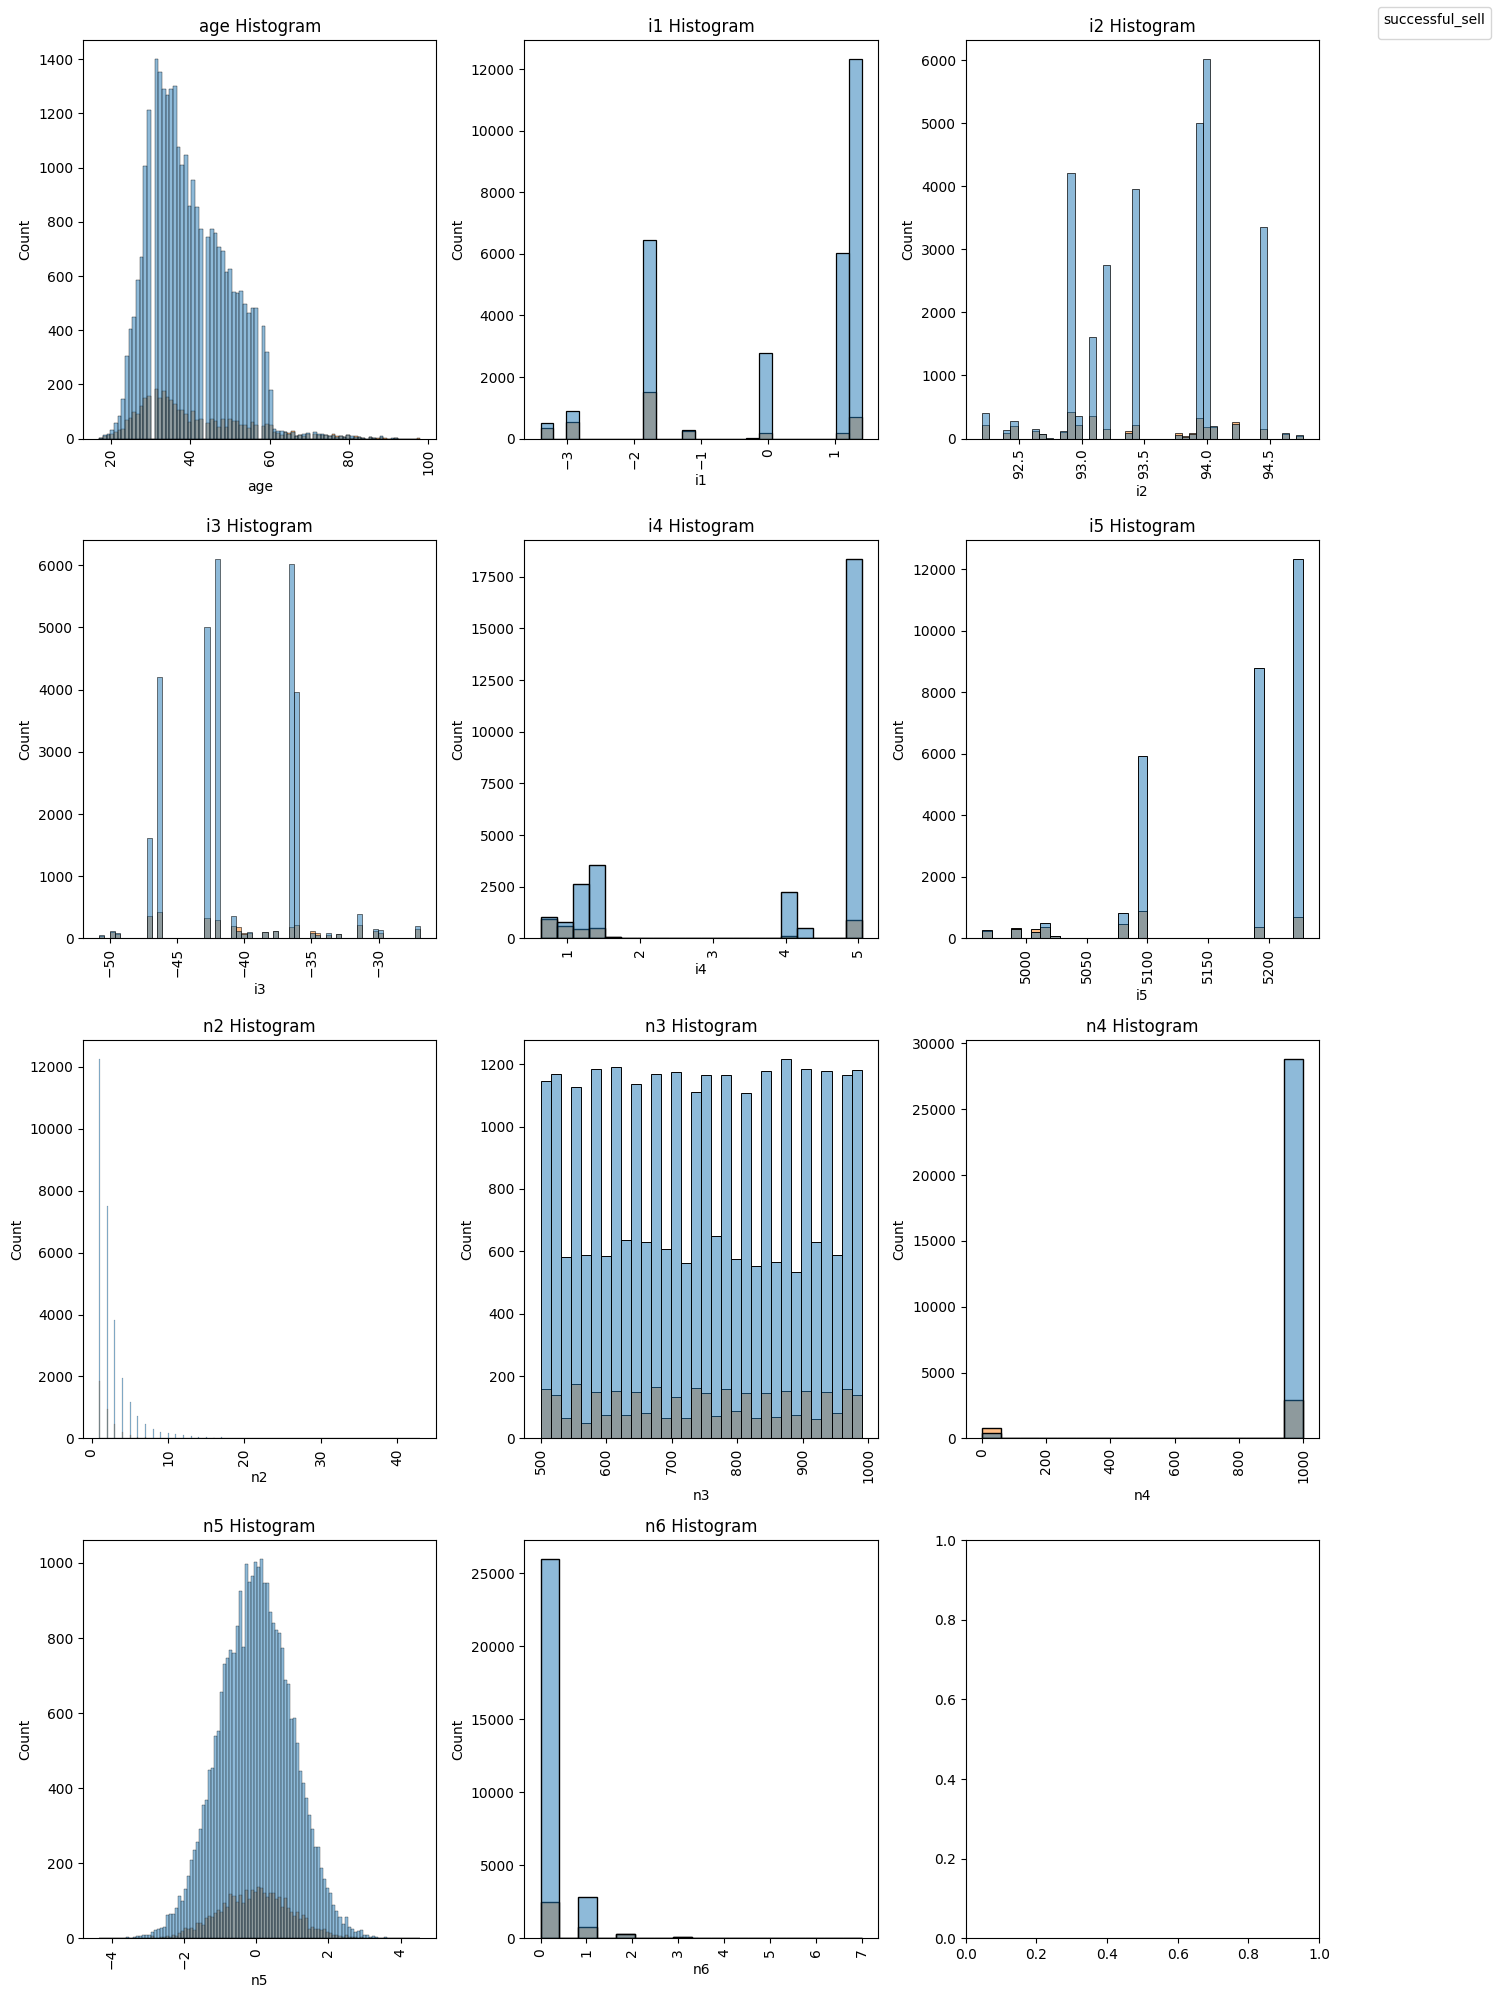

In [90]:
num_cols = [col for col in df_train.columns if col not in cat_cols] 


fig, axes = plt.subplots(4, 3, figsize=(15, 20))

axes = axes.flatten()

# Store handles and labels for the legend
handles, labels = None, None

# Iterate over the categorical columns and plot each one
for i, col in enumerate(num_cols):
    ax = axes[i]
    
    # Create count plot
    plot = sns.histplot(x=col, hue='successful_sell', data=df_train, ax=ax)
    
    # Capture handles and labels from the first plot
    if i == 0:
        handles, labels = ax.get_legend_handles_labels()
    
    # Remove individual legends if they exist
    if ax.get_legend() is not None:
        ax.get_legend().remove()
    
    # Set the title of the subplot
    ax.set_title(f'{col} Histogram')
    
    # Set the labels for x and y axes
    ax.set_xlabel(col)
    ax.set_ylabel('Count')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

# Create one legend for the entire plot
fig.legend(handles, labels, title='successful_sell', loc='upper right')

# Adjust the layout and display the plot
plt.tight_layout(rect=[0, 0, 0.9, 1])  # Leave space for the legend
plt.show()

## **Notes on Numeric Columns (Univariate Description)**

1. `Age`: Visual inspection seems like what you would expect from this variable. Steep drop off at retirement age. Sale seems to be visually independent of age, but might be something there models could pick up. 
2. `i1`: Not really sure what is going on with this variable. Seems like values < 0 are associated with higher sale percentage. 
3. `i2`: Variable has low variance for the values, seems like the extreme values could be associated with higher sale percentage. 
4. `i3`: Variable **looks** similar to `i2`, but with a larger variance and flipped relationship - something like `i2` $= -.5$`i1` $+ \epsilon$. Will need to check for colinearity.  
5. `i4` and `i5`: **Look** similar to `i1` both being on a differnent scale and having different variances. Need to check for colinearity. 
6. `n2` and `n6`: Look poisson distributed. Not a strong visual relationship between sale and these variables. `n2` has a much larger tail than `n6` with a max value of 43 vs 7.
7. `n3`: Looks to be uniform distributed (some weird binning things happening in the histogram). Not a strong relationship between it and sale.
8. `n4` Looks like we have values ranging from 0 to 27 and then 999. 999 is probably the missing encoding. 1209 rows in training set have non-missing `n4` under this assumption and seem to be associated more strongly with successful sale. Will need to investigate further to see how the non-missing values are associated with sale to decide on an imputation method. 
9. `n5`: Looks normally distributed with no obvious association with sale.    

Text(0.5, 1.0, 'n4 Histogram')

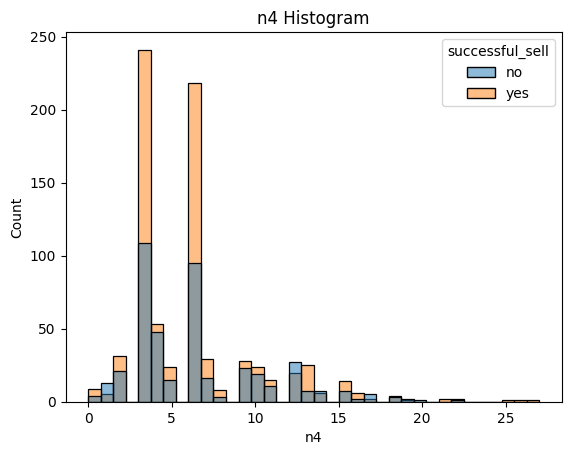

In [98]:
sns.histplot(df_train.filter(pl.col('n4') < 999), x='n4', hue='successful_sell')
plt.title('n4 Histogram')

In [116]:
df_train = df_train.with_columns(
    pl.when(pl.col('n4') == 999).then(None).otherwise(pl.col('n4')).alias('n4'))  # Replace 999 with null values in column 'n4'

I don't see an obvious relationship between sale and n4 besides the non-missing values being a lot more likely to make a sale. 

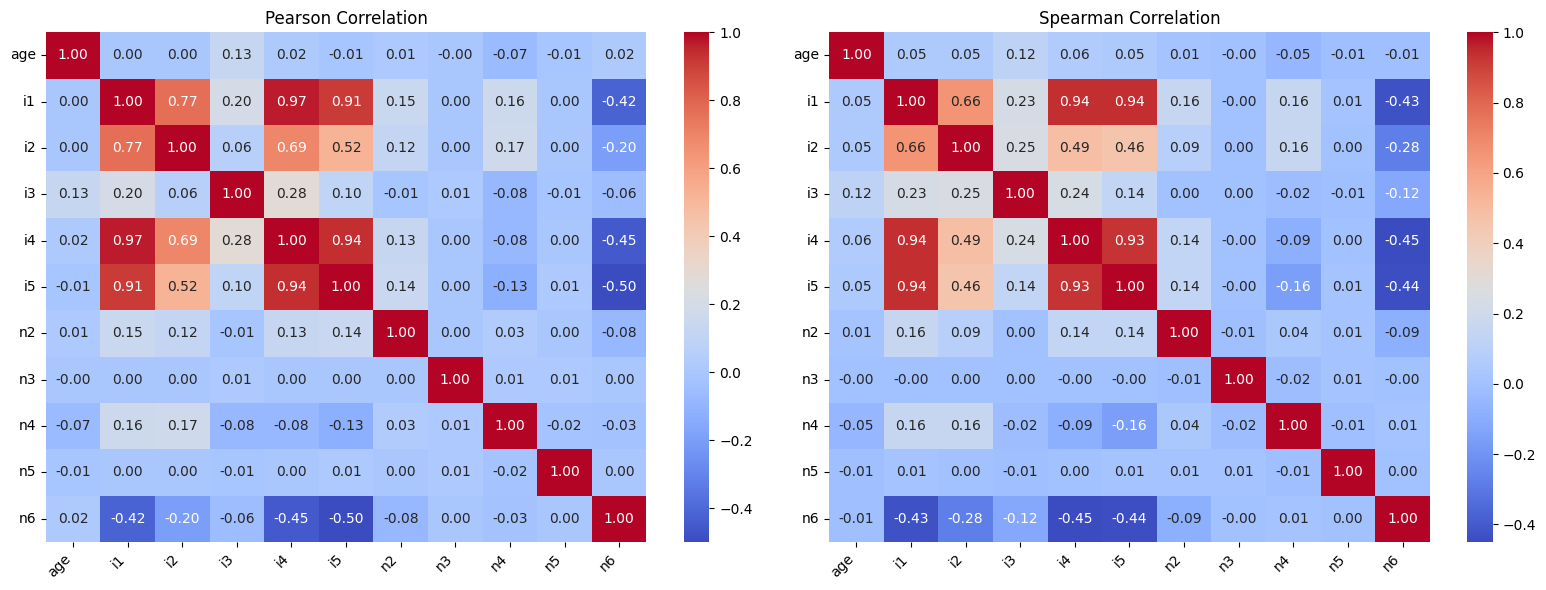

In [129]:
pearson_corr = df_train.select(num_cols).to_pandas().corr('pearson').round(2)
spearman_corr = df_train.select(num_cols).to_pandas().corr('spearman').round(2)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Heatmap for Pearson correlation
sns.heatmap(pearson_corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, ax=axes[0])
axes[0].set_title('Pearson Correlation')
axes[0].set_xticklabels(pearson_corr.columns, rotation=45, horizontalalignment='right')
axes[0].set_yticklabels(pearson_corr.columns, rotation=0)

# Heatmap for Spearman correlation
sns.heatmap(spearman_corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, ax=axes[1])
axes[1].set_title('Spearman Correlation')
axes[1].set_xticklabels(spearman_corr.columns, rotation=45, horizontalalignment='right')
axes[1].set_yticklabels(spearman_corr.columns, rotation=0)

# Adjust layout
plt.tight_layout()
plt.show()

We see some strong correlation between the following:

1. `i1`, `i4`, and `i5`. These are all pairwise heavily correlated with one another. 
2. `i1` and `i2` (and thereby moderately strong between `i4` and `i5`)

And moderately strong correlation between:

3. `n6` and `i1`, `i2`, `i4`, and `i5`

We will want to consider dropping columns to get rid of these, using models that have regularization built in (e.g. penalzied logistic regression), some sort of stepwise feature elimination, or PCA (though we lose interpretation).



We need to take care of missing values before doing anything else. 

## Missing Values

### Categorical Variables 

Without more domain knowledge or knowledge of the data, it would be more conservative to model missing values as missing directly than to use an imputation method. If we could assume MCAR we could utilize joint imputation to impute the values using non-missing values in other features. We could consider adding imputation into our hyperparmeter tuning process, but we won't due to time constraints for this problem. 


### Numeric Variables

None of the variables have missing values, but `n4` again has encoded missingness as 999. We could consider encoding `n4` as a binary variable with 0 as missing and 1 as non-missing - would need to do some checks to make sure this is a smart decision (e.g.looking at joint distributions with other predictors), but will run with it for now.

